In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import scikitplot as skplt
import numpy as np
import keras
import tensorflow as tf

# Carregando base de dados  pré-processada

In [2]:
database = pd.read_csv("../../Database/dataBaseWithNER.csv")

database = database.drop(columns=["Unnamed: 0"])
database = database.dropna()
target = database["target"].array
database

,email,target
0,start date hourahead timee cardinall hou...,0
1,service long desk price structure deal quote ...,0
2,start date cardinall hourahead timee card...,0
3,start date hourahead timee cardinall anc...,0
4,cardinall deliverable revenue management marke...,0
...,...,...
33340,bio matrix scientific group symbo bmxg p...,1
33341,cardinall step away hot naked webcam girl liv...,1
33342,need pill increase performance click seroius ...,1
33343,datee final nom inlet hpl eastrans car...,0


In [3]:
emailsText = []
for email in database["email"]:
    emailsText.append(email)

In [4]:
print(len(emailsText))

33341


# Representação vetorial Bag of Words

In [5]:
vectorizer = CountVectorizer(max_features=2100)
X = vectorizer.fit_transform(emailsText)

bag = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())

bag

,aa,ability,able,absolutely,abuse,accept,acceptance,accepted,access,according,...,xanax,xl,xp,yahoo,year,yes,yield,yo,young,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33336,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
33337,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
33338,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33339,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Visualização de dados com TSNE

In [6]:
#model = TSNE(n_components=2, random_state=0)
##model = PCA(n_components=50, svd_solver='full')
#array_red = model.fit_transform(bag)
#
#df_tsne = pd.DataFrame(array_red)
#
#df_tsne['Target'] = target
#df_tsne_c1 = df_tsne[df_tsne['Target'] == 0]
#
#df_tsne_c2 = df_tsne[df_tsne['Target'] == 1]
#
#plt.scatter(df_tsne_c1[0].array,df_tsne_c1[1].array,marker='o',color='blue')
#
#plt.scatter(df_tsne_c2[0].array,df_tsne_c2[1].array,marker='o',color='red')
#
#plt.title('Dados')
#plt.xlabel('x')
#plt.ylabel('y')
#
#plt.show()

# Validação

In [7]:
X_treino, X_teste, y_treino, y_teste = train_test_split(bag.values, target, test_size=0.2)


In [8]:
X_treino = np.array(X_treino)

X_treino = X_treino.reshape((X_treino.shape[0],1,X_treino.shape[1]))
print(X_treino.shape)

(26672, 1, 2100)


In [9]:
model = keras.models.Sequential([


######## Conv
keras.layers.Conv1D(640, kernel_size=1, activation="relu",input_shape=X_treino.shape[1:]),
keras.layers.MaxPooling1D(pool_size=1),
keras.layers.Dropout(0.5),
keras.layers.Flatten(),
keras.layers.Dense(5000, activation="relu"),
keras.layers.Dropout(0.5),
keras.layers.Dense(len(set(target)), activation="softmax")
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 640)            1344640   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 640)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1, 640)            0         
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense (Dense)               (None, 5000)              3205000   
                                                                 
 dropout_1 (Dropout)         (None, 5000)              0         
                                                        

In [11]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [12]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4,mode='min'), tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0, restore_best_weights=True)]

history = model.fit(np.array(X_treino), np.array(y_treino), epochs=200,validation_split=0.05,callbacks=callbacks)

Epoch 1/200
792/792 [==============================] - 14s 18ms/step - loss: 0.4255 - accuracy: 0.8360 - val_loss: 0.2414 - val_accuracy: 0.9213 - lr: 0.0100
Epoch 2/200
792/792 [==============================] - 12s 16ms/step - loss: 0.2425 - accuracy: 0.9256 - val_loss: 0.1380 - val_accuracy: 0.9610 - lr: 0.0100
Epoch 3/200
792/792 [==============================] - 12s 15ms/step - loss: 0.1701 - accuracy: 0.9463 - val_loss: 0.1126 - val_accuracy: 0.9625 - lr: 0.0100
Epoch 4/200
792/792 [==============================] - 13s 16ms/step - loss: 0.1330 - accuracy: 0.9562 - val_loss: 0.0875 - val_accuracy: 0.9693 - lr: 0.0100
Epoch 5/200
102/792 [==>...........................] - ETA: 10s - loss: 0.1241 - accuracy: 0.9547

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.xlabel('epoch')
plt.show()

In [ ]:
model.evaluate(np.array(bag.values), np.array(target))

(array([0, 1]), [Text(0, 0, 'Ham'), Text(1, 0, 'Spam')])

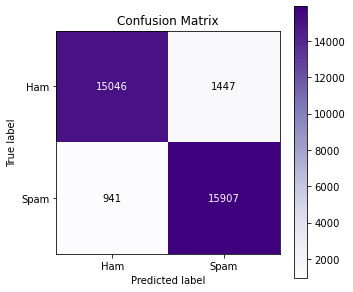

In [16]:
categories = ["Ham", "Spam"]

skplt.metrics.plot_confusion_matrix(
    [categories[i] for i in target], [categories[i] for i in predicoes.tolist()],
    title="Confusion Matrix",
    cmap="Purples",
    hide_zeros=True,
    figsize=(5,5)
)

plt.xticks()